In [7]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating environment at `~/JuliaProjects/Clustering-ToMaTo/Project.toml`


In [48]:
using LinearAlgebra
using SparseArrays
using LightGraphs
using DelimitedFiles
using Arpack

In [37]:
using Revise
using ClusteringToMaTo

In [20]:
function powermethod(A::Array,error=1e-12,maxitr=200)
    dim=size(A,2)
    u = rand(dim)
    large=0.0
    itr=0
    err=1
    while(err>error || itr<maxitr)
        mu=Array{Float64,1}(dim)
        v=A*u;
        mu=norm(v,2);
        err=abs(large-mu)
        large=copy(mu)
        u=v/mu;
        itr=itr+1
    end
    return large, u
end

powermethod (generic function with 3 methods)

In [21]:
function sp_powermethod(A::SparseMatrixCSC,error=1e-12,maxitr=200)
    dim=size(A,2)
    u=sprand(Float64, dim, 1,1.0)
    large=0.0
    itr=0
    err=1
    while(err>error || itr<maxitr)
        #mu=SparseMatrixCSC{Float64,Int64}()
        v=A*u;
        mu=norm(v,2);
        err=abs(large-mu)
        large=copy(mu)
        #print(large," ")
        u=v/mu;
        itr=itr+1
    end
    return large, Array(u)
end

sp_powermethod (generic function with 3 methods)

In [24]:
T = Int.(readdlm(joinpath("email-Eu-core.txt"))) .+ 1

25571×2 Matrix{Int64}:
   0    1
   2    3
   2    4
   5    6
   5    7
   8    9
  10   11
  12   13
  12   14
  15   16
  17   18
  12   19
  20   21
   ⋮  
 900   13
 241  232
 420   28
 256   87
  28  420
 420  285
  87  227
 420  143
 174  859
 440  460
  52  786
 506  932

In [26]:
G=SimpleGraph(maximum(T))
G

{1005, 0} undirected simple Int64 graph

In [27]:
for i = 1:size(T,1)
    add_edge!(G,T[i,1],T[i,2])
end

In [28]:
aG = [(neighbors(G,i)) for i in vertices(G)]

1005-element Vector{Vector{Int64}}:
 [1, 2, 6, 7, 18, 19, 65, 66, 74, 75  …  314, 317, 369, 378, 381, 460, 499, 561, 582, 735]
 [1, 2, 18, 22, 53, 75, 83, 85, 86, 107  …  496, 538, 549, 550, 561, 569, 617, 642, 727, 980]
 [3, 4, 5, 6, 7, 14, 55, 56, 57, 58  …  846, 860, 866, 881, 887, 897, 900, 972, 991, 1002]
 [3, 4, 5, 7, 47, 56, 57, 58, 59, 60  …  813, 833, 846, 860, 881, 887, 933, 972, 991, 1002]
 [3, 4, 5, 7, 14, 55, 56, 57, 58, 59  …  813, 827, 833, 846, 860, 881, 897, 972, 991, 1002]
 [1, 3, 6, 7, 8, 12, 22, 25, 30, 35  …  829, 834, 841, 860, 869, 901, 903, 932, 981, 991]
 [1, 3, 4, 5, 6, 7, 22, 55, 56, 57  …  739, 752, 827, 846, 860, 881, 922, 950, 995, 1002]
 [6, 8, 9, 12, 13, 20, 45, 63, 87, 113  …  708, 721, 755, 766, 824, 834, 857, 914, 923, 957]
 [8, 9, 10, 12, 13, 45, 63, 87, 108, 142  …  567, 570, 571, 574, 662, 673, 824, 857, 951, 972]
 [9, 10, 20, 45, 142, 214, 265, 266, 267, 333  …  662, 675, 700, 708, 721, 755, 766, 824, 958, 972]
 [12, 14, 21, 22, 26, 37, 45, 65, 70

In [29]:
A = adjacency_matrix(G)

1005×1005 SparseMatrixCSC{Int64, Int64} with 32770 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⣟⣟⡿⣻⣿⢿⢿⢛⣷⢟⣿⣓⢹⣽⣿⢺⡟⠟
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣿⣷⣿⣟⢿⣿⣿⣿⣿⣞⣟⣿⣻⣿⣻⣿⣺⣿⡚
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⣿⣿⣿⣿⣿⣿⣯⣽⣯⣿⣏⣯⣽⣽⣯⡤⣿⢽⣟⢿⣿⢽⣿⣆
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⡿⣿⢿⣻⣿⣿⣾⣿⣲⣳⣿⣾⡿⢾⣾⡺⡟⣒
⣿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⣿⡿⣿⣿⡿⣿⣾⣿⣿⣿⣮⢷⡎⣿⣶⠻⡎⠱⣻⢟⣲⠾⢿⢝⣏⠪
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣼⡿⣿⣿⣿⡭⢼⣿⣽⣯⣺⢿⣼⠕⢎
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⢿⣿⣿⡻⡻⢿⠟⣆⢎⣯⢯⣿⣿⣽⠼⡷⡅
⣿⡿⣿⣿⡿⣿⣿⡿⣿⡿⣿⣿⣿⣿⢿⣷⣿⣻⣿⣿⣿⣿⡿⡻⣫⣯⢿⡟⢻⢽⣯⠝⡚⡾⡧⢾⢝⢹⡟⠄
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⢻⣿⣙⣟⣻⠟⢟⣿⣿⠟⠯⣿⠽⣿⠅
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⣿⣟⣼⣿⣬⣿⣝⣧⣳⣿⣽⠃⡺⣿⢴⡿⠂
⣿⣿⣾⣿⣿⣿⣿⣿⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢾⣷⣟⣪⣯⣿⣳⣮⣳⣢⣿⢺⣢⢨⣯⣸⣗⠂
⣿⢽⣽⣿⣏⣿⣿⣯⣿⣿⣿⡿⣯⣟⣿⡫⣿⣿⣯⣿⢾⣷⣟⣽⣇⢍⠾⢑⡏⣞⣚⠈⣽⠛⡨⣀⣹⣳⢇⠈
⣿⣫⣿⣝⣯⣿⣿⣳⢮⣟⣛⣿⣿⣿⡯⣾⣿⣛⣛⣽⡻⣹⡍⢝⢛⢔⠺⣈⢫⠩⠐⡋⢞⠈⠁⠠⢈⢍⡃⠀
⣿⣟⣿⣿⡯⣽⣿⣿⣮⣭⣿⣯⣿⡪⣿⠷⣟⢻⡛⣿⣯⣿⢞⢃⡚⢢⡿⣯⣃⡜⠀⠂⣽⡬⠥⠁⣐⢨⡊⠄
⣿⢓⣿⣿⣗⣿⣾⣿⣼⡛⣿⣿⣿⠗⣟⣖⣿⣹⣟⢿⡹⣾⣫⢭⡏⡒⣉⠼⣻⢞⢳⣙⣽⠛⡈⢊⣱⣉⣇⠁
⣽⢟⣾⢽⠋⡿⢼⣺⢎⡉⣃⣏⡨⢝⣏⠟⣿⢅⢭⣻⠹⣺⡚⠘⡴⠠⠠⠀⣝⢲⡑⢌⣐⠌⡂⠐⠃⠃⡊⣀
⢿⢻⣿⣻⣟⣟⣻⣿⣿⢞⣟⣿⡯⣟⣺⡬⣿⣿⣟⣿⣻⣛⣷⠛⡚⠑⡓⡿⣷⠛⡐⠜⢟⣵⡏⢓⣿⢺⢗⠓
⣗⣶⣿⣻⣿⣝⣻⣏⣸⡞⣫⣻⣿⣿⣩⣏⡿⡅⣩⡠⡈⣚⠂⢪⠁⡀⠅⠃⡢⢈⢈⠈⢯⢉⡟⣭⣋⣐⢍⡁
⣻⣛⣻⣻⣟⣟⣺⡻⣟⢗⣛⣷⣓⡟⣗⣑⣟⡟⢛⣟⣋⣻⢷⣺⡆⢔⡐⣘⡕⢺⠭⠀⣻⣛⢋⢸⣛⣼⡟⡉
⣿⠍⣻⠻⠻⢿⢻⢩⡫⡙⡱⢅⠝⠯⠛⠍⠟⠟⠻⠋⠹⠙⡉⠑⠉⠈⠊⠌⠍⠙⠊⢨⢽⠑⠇⠱⡟⠩⠛⡤

In [30]:
A == A'

true

In [32]:
writedlm(joinpath("adj1006_2.txt"), A)

In [33]:
B = float.(A')

1005×1005 SparseMatrixCSC{Float64, Int64} with 32770 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⣟⣟⡿⣻⣿⢿⢿⢛⣷⢟⣿⣓⢹⣽⣿⢺⡟⠟
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣿⣷⣿⣟⢿⣿⣿⣿⣿⣞⣟⣿⣻⣿⣻⣿⣺⣿⡚
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⣿⣿⣿⣿⣿⣿⣯⣽⣯⣿⣏⣯⣽⣽⣯⡤⣿⢽⣟⢿⣿⢽⣿⣆
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⡿⣿⢿⣻⣿⣿⣾⣿⣲⣳⣿⣾⡿⢾⣾⡺⡟⣒
⣿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⣿⡿⣿⣿⡿⣿⣾⣿⣿⣿⣮⢷⡎⣿⣶⠻⡎⠱⣻⢟⣲⠾⢿⢝⣏⠪
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣼⡿⣿⣿⣿⡭⢼⣿⣽⣯⣺⢿⣼⠕⢎
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⢿⣿⣿⡻⡻⢿⠟⣆⢎⣯⢯⣿⣿⣽⠼⡷⡅
⣿⡿⣿⣿⡿⣿⣿⡿⣿⡿⣿⣿⣿⣿⢿⣷⣿⣻⣿⣿⣿⣿⡿⡻⣫⣯⢿⡟⢻⢽⣯⠝⡚⡾⡧⢾⢝⢹⡟⠄
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⢻⣿⣙⣟⣻⠟⢟⣿⣿⠟⠯⣿⠽⣿⠅
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⣿⣟⣼⣿⣬⣿⣝⣧⣳⣿⣽⠃⡺⣿⢴⡿⠂
⣿⣿⣾⣿⣿⣿⣿⣿⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢾⣷⣟⣪⣯⣿⣳⣮⣳⣢⣿⢺⣢⢨⣯⣸⣗⠂
⣿⢽⣽⣿⣏⣿⣿⣯⣿⣿⣿⡿⣯⣟⣿⡫⣿⣿⣯⣿⢾⣷⣟⣽⣇⢍⠾⢑⡏⣞⣚⠈⣽⠛⡨⣀⣹⣳⢇⠈
⣿⣫⣿⣝⣯⣿⣿⣳⢮⣟⣛⣿⣿⣿⡯⣾⣿⣛⣛⣽⡻⣹⡍⢝⢛⢔⠺⣈⢫⠩⠐⡋⢞⠈⠁⠠⢈⢍⡃⠀
⣿⣟⣿⣿⡯⣽⣿⣿⣮⣭⣿⣯⣿⡪⣿⠷⣟⢻⡛⣿⣯⣿⢞⢃⡚⢢⡿⣯⣃⡜⠀⠂⣽⡬⠥⠁⣐⢨⡊⠄
⣿⢓⣿⣿⣗⣿⣾⣿⣼⡛⣿⣿⣿⠗⣟⣖⣿⣹⣟⢿⡹⣾⣫⢭⡏⡒⣉⠼⣻⢞⢳⣙⣽⠛⡈⢊⣱⣉⣇⠁
⣽⢟⣾⢽⠋⡿⢼⣺⢎⡉⣃⣏⡨⢝⣏⠟⣿⢅⢭⣻⠹⣺⡚⠘⡴⠠⠠⠀⣝⢲⡑⢌⣐⠌⡂⠐⠃⠃⡊⣀
⢿⢻⣿⣻⣟⣟⣻⣿⣿⢞⣟⣿⡯⣟⣺⡬⣿⣿⣟⣿⣻⣛⣷⠛⡚⠑⡓⡿⣷⠛⡐⠜⢟⣵⡏⢓⣿⢺⢗⠓
⣗⣶⣿⣻⣿⣝⣻⣏⣸⡞⣫⣻⣿⣿⣩⣏⡿⡅⣩⡠⡈⣚⠂⢪⠁⡀⠅⠃⡢⢈⢈⠈⢯⢉⡟⣭⣋⣐⢍⡁
⣻⣛⣻⣻⣟⣟⣺⡻⣟⢗⣛⣷⣓⡟⣗⣑⣟⡟⢛⣟⣋⣻⢷⣺⡆⢔⡐⣘⡕⢺⠭⠀⣻⣛⢋⢸⣛⣼⡟⡉
⣿⠍⣻⠻⠻⢿⢻⢩⡫⡙⡱⢅⠝⠯⠛⠍⠟⠟⠻⠋⠹⠙⡉⠑⠉⠈⠊⠌⠍⠙⠊⢨⢽⠑⠇⠱⡟⠩⠛⡤

In [34]:
for i=1:1005
    soB=sum(view(B,:,i))
    for j=1:1005
        B[j,i] != 0 && (B[j,i] = B[j,i]/soB)
    end
end

In [35]:
l, f = sp_powermethod(B,0,1000)

(1.0, [0.027627508560532196; 0.0326506919351744; … ; 0.0006278979218302765; 0.000627897921830277])

In [38]:
S, u = Clustering(aG, f, 0.005)

20-element Vector{Any}:
 (659, [659])
 (161, [161, 122, 83, 108, 87, 63, 435, 14, 167, 184  …  999, 651, 902, 944, 983, 900, 775, 876, 974, 976])
 (634, [634])
 (704, [704])
 (745, [745])
 (809, [809])
 (649, [649])
 (671, [671])
 (712, [712])
 (581, [581])
 (773, [773])
 (654, [654])
 (676, [676])
 (692, [692])
 (747, [747])
 (685, [685])
 (732, [732])
 (733, [733])
 (661, [661])
 (799, [799])

In [39]:
S

(659, [659])

In [22]:
function plotGraphCluster(G,S)

    u1=copy(u)
    for i=1:size(u1,1), j=1:size(S,1)
        u1[i]==S[j][1] && ( u1[i]=j )
    end
    for j=1:size(u1,1)
        u1[j]>size(S,1) && ( u1[j]=size(S,1)+1 )
    end
    if size(S,1)!=0
        
        colors=[RGB.(rand(),rand(),rand()) for i=1:size(S,1)+1]
        colors[end]=RGB.(0,0,0)

        membership=u1
        nodecolor = colors
        nodefillc = nodecolor[membership]
        draw(PNG("graph.png", 100cm, 100cm), gplot(G,nodefillc=nodefillc))
        return S,u1
    else
        return 1
    end
end

plotGraphCluster (generic function with 1 method)

In [41]:
u

(161, [161, 122, 83, 108, 87, 63, 435, 14, 167, 184  …  999, 651, 902, 944, 983, 900, 775, 876, 974, 976])

In [43]:
u1 = u .+ 1

LoadError: MethodError: no method matching +(::Vector{Int64}, ::Int64)
For element-wise addition, use broadcasting with dot syntax: array .+ scalar
[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:560
[0m  +([91m::T[39m, ::T) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} at int.jl:87
[0m  +(::Array, [91m::Array...[39m) at arraymath.jl:43
[0m  ...

In [44]:
neighbors(G,1005)

1-element Vector{Int64}:
 56

In [45]:
writedlm(joinpath("lp.txt"),A)

In [49]:
e=eigs(A)

([78.07962557516342, 37.890131484190036, 34.99862448326542, 33.100081293645594, 31.306194590985186, 27.26476098670435], [-0.01870212210664782 0.015307526405456613 … -0.005918164431003051 0.034345662273808183; -0.0291533472517131 0.027812892504227523 … -0.029822484844796934 0.011579574131346929; … ; -0.0004619275897397893 8.627942287741804e-5 … -0.00031649294608076454 -0.00036318546110825436; -0.00033477455526009916 -0.0026507453969854653 … 0.0005541706763987626 -1.1199869794083044e-6], 6, 6, 78, [0.34673863722705783, -0.19561575372333725, -0.1868320194949585, -0.11834951145837444, -0.44720992832920176, 0.4766725162932265, -0.2213690857556381, -0.1944348482594841, 0.3716218807912797, 0.1015931323869814  …  -0.2346058632435286, -0.05892268662049084, 0.06964457929108497, 0.12129801543308501, 0.11683794441917805, 0.13500434492411656, -0.0022363366292862384, 0.028037698663168076, 0.07714959971802263, -0.05257595239462029])

In [50]:
maximum(e[2][:,1]-v2)

LoadError: UndefVarError: v2 not defined

In [51]:
writedlm(joinpath("aj.txt"),aj)

LoadError: UndefVarError: aj not defined

In [21]:
@time large,v=sp_powermethod(A,0,100000)

 17.317310 seconds (2.71 M allocations: 32.360 GiB, 9.12% gc time)


(346.0806967154038, [0.000184427; 0.000373764; … ; 9.13609e-6; 8.90489e-6])

In [9]:
include("ToMaTo.jl")
import ToMaTo

In [6]:
using Distances, Plots, DataStructures, NearestNeighbors,LightGraphs, GraphPlot

In [7]:
using Colors, Compose, GraphPlot

In [52]:
@time S,u=ToMaTo.Clustering(aG,v2,0.001)

  0.001760 seconds (2.16 k allocations: 96.961 KiB)


(Array{Int64,1}[[10, 13], [12, 11, 15, 7, 4, 8, 5, 14], [18, 16, 17], [1, 9, 3, 6, 2], [23, 20, 22, 24, 26, 27, 25, 21, 19]], [23, 12, 18, 10, 18, 18, 10, 12, 12, 12  …  23, 23, 23, 23, 23, 23, 23, 12, 23, 12])

In [53]:
S

5-element Array{Array{Int64,1},1}:
 [10, 13]                            
 [12, 11, 15, 7, 4, 8, 5, 14]        
 [18, 16, 17]                        
 [1, 9, 3, 6, 2]                     
 [23, 20, 22, 24, 26, 27, 25, 21, 19]

In [55]:
    u1=copy(u)
    for i=1:size(u1,1)
        for j=1:size(S,1)
            if u1[i]==S[j][1]
                u1[i]=j
            end
        end
    end
    for j=1:size(u1,1)
        if u1[j]>size(S,1)
            u1[j]=size(S,1)+1
        end
    end
    if size(S,1)!=0
        colors=[RGB.(rand(),rand(),rand()) for i=1:size(S,1)+1]
        colors[end]=RGB.(0,0,0)

        membership=u1
        nodecolor = colors
        nodefillc = nodecolor[membership]
        draw(PNG("graph.png", 100cm, 100cm), gplot(G,nodefillc=nodefillc))
        return S,u1
    else
        return 1
    end

(Array{Int64,1}[[10, 13], [12, 11, 15, 7, 4, 8, 5, 14], [18, 16, 17], [1, 9, 3, 6, 2], [23, 20, 22, 24, 26, 27, 25, 21, 19]], [5, 2, 3, 4, 3, 3, 4, 2, 2, 2  …  5, 5, 5, 5, 5, 5, 5, 2, 5, 2])

In [66]:
writedlm("example.txt",B)

In [82]:
points = 0 
for s in S
    points = points + size(s,1)
end
points

855

In [41]:
Graph_laplacian(G,0,10000,0.0005)

(Array{Int64,1}[[14, 302, 410, 272, 204, 96, 89, 662, 119, 127  …  738, 677, 370, 299, 295, 447, 429, 151, 26, 41], [161, 725, 822, 878, 288, 513, 897, 858, 560, 455  …  129, 22, 821, 250, 130, 184, 378, 85, 83, 122], [63, 87, 435, 65, 6, 421, 212, 7, 474, 933  …  494, 219, 257, 441, 270, 233, 142, 66, 534, 108]], [2, 3, 3, 3, 1, 3, 3, 3, 1, 3  …  2, 2, 2, 3, 2, 2, 2, 2, 2, 2])

In [127]:
T=Int.(readdlm(".\\edges.txt"))

16×2 Array{Int64,2}:
 1  2
 2  3
 4  5
 5  6
 7  8
 8  9
 1  4
 4  7
 2  5
 5  8
 3  6
 6  9
 1  5
 3  5
 7  5
 9  5

In [128]:
G=0

0

In [129]:
G=Graph(27)

{27, 0} undirected simple Int64 graph

In [130]:
for i = 1:size(T,1)
    add_edge!(G,T[i,1],T[i,2])
end
for i = 1:size(T,1)
    add_edge!(G,T[i,1]+9,T[i,2]+9)
end
for i = 1:size(T,1)
    add_edge!(G,T[i,1]+18,T[i,2]+18)
end
add_edge!(G,7,12)
add_edge!(G,12,19)
add_edge!(G,7,19)

true

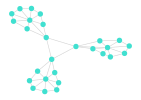

In [131]:
gplot(G)

In [10]:
G=SimpleDiGraph(6)

{6, 0} directed simple Int64 graph

In [11]:
add_edge!(G,1,2)
add_edge!(G,3,1)
add_edge!(G,2,3)
add_edge!(G,3,4)
add_edge!(G,4,3)
add_edge!(G,5,4)
add_edge!(G,6,5)
add_edge!(G,4,6)

true

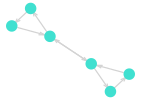

In [12]:
gplot(G)

In [13]:
A=laplacian_matrix(G)

6×6 SparseMatrixCSC{Int64,Int64} with 20 stored entries:
  [1, 1]  =  2
  [2, 1]  =  -1
  [3, 1]  =  -1
  [1, 2]  =  -1
  [2, 2]  =  2
  [3, 2]  =  -1
  [1, 3]  =  -1
  [2, 3]  =  -1
  [3, 3]  =  3
  [4, 3]  =  -1
  [3, 4]  =  -1
  [4, 4]  =  3
  [5, 4]  =  -1
  [6, 4]  =  -1
  [4, 5]  =  -1
  [5, 5]  =  2
  [6, 5]  =  -1
  [4, 6]  =  -1
  [5, 6]  =  -1
  [6, 6]  =  2

In [31]:
l,u=sp_powermethod(A,0,1000)

(4.561552812808831, [0.184524; 0.184524; … ; -0.184524; -0.184524])

In [37]:
l,u=powermethod(B,0,1000)

(4.561552812808831, [-0.184524, -0.184524, 0.657192, -0.657192, 0.184524, 0.184524])

In [38]:
u

6-element Array{Float64,1}:
 -0.184524
 -0.184524
  0.657192
 -0.657192
  0.184524
  0.184524

In [10]:
test=Array(laplacian_matrix(G))

9×9 Array{Int64,2}:
  2  -1  -1   0   0   0   0   0   0
 -1   2  -1   0   0   0   0   0   0
 -1  -1   4  -1   0   0  -1   0   0
  0   0  -1   4  -1  -1  -1   0   0
  0   0   0  -1   2  -1   0   0   0
  0   0   0  -1  -1   2   0   0   0
  0   0  -1  -1   0   0   4  -1  -1
  0   0   0   0   0   0  -1   2  -1
  0   0   0   0   0   0  -1  -1   2

In [91]:
(sqrt(17)+5)/2

4.561552812808831

In [10]:
Graph_laplacian(G,0,5000,0.002)

(Array{Int64,1}[[25, 26], [19, 12, 20, 22, 11, 15, 14, 23], [21, 27, 24], [10, 18, 16, 13, 17], [5, 4, 8, 2, 6, 3, 1, 9, 7]], [5, 2, 3, 1, 3, 3, 1, 2, 2, 2  …  5, 5, 5, 5, 5, 5, 5, 5, 2, 2])

In [11]:
large,v=sp_powermethod(laplacian_matrix(G),0,10000)

(9.085432554310831, [0.056611; 0.0545994; … ; -0.0925363; -0.0932067])

In [27]:
B=Array(laplacian_matrix(G))

27×27 Array{Int64,2}:
  3  -1   0  -1  -1   0   0   0   0  …   0   0   0   0   0   0   0   0   0
 -1   3  -1   0  -1   0   0   0   0      0   0   0   0   0   0   0   0   0
  0  -1   3   0  -1  -1   0   0   0      0   0   0   0   0   0   0   0   0
 -1   0   0   3  -1   0  -1   0   0      0   0   0   0   0   0   0   0   0
 -1  -1  -1  -1   8  -1  -1  -1  -1      0   0   0   0   0   0   0   0   0
  0   0  -1   0  -1   3   0   0  -1  …   0   0   0   0   0   0   0   0   0
  0   0   0  -1  -1   0   5  -1   0     -1   0   0   0   0   0   0   0   0
  0   0   0   0  -1   0  -1   3  -1      0   0   0   0   0   0   0   0   0
  0   0   0   0  -1  -1   0  -1   3      0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0  …   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0  -1   0   0     -1   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
  ⋮

In [38]:
u=eigvecs(B)

27×27 Array{Float64,2}:
 -0.19245   0.261084     0.127141   …  -0.0680414   0.0935794   0.0234084
 -0.19245   0.277298     0.135037      -0.0680414   0.0902541   0.0225766
 -0.19245   0.281523     0.137095      -0.0680414   0.090908    0.0227402
 -0.19245   0.219304     0.106796      -0.0680414   0.0739975   0.0185101
 -0.19245   0.244196     0.118918       0.544331   -0.733723   -0.183537 
 -0.19245   0.277298     0.135037   …  -0.0680414   0.0902541   0.0225766
 -0.19245   0.116971     0.0569618     -0.0680414   0.189836    0.0474866
 -0.19245   0.219304     0.106796      -0.0680414   0.0739975   0.0185101
 -0.19245   0.261084     0.127141      -0.0680414   0.0935794   0.0234084
 -0.19245  -0.24065      0.162534      -0.0680414  -0.067062    0.0693379
 -0.19245  -0.202139     0.136525   …  -0.0680414  -0.053029    0.0548287
 -0.19245  -0.107816     0.0728186     -0.0680414  -0.136043    0.14066  
 -0.19245  -0.255595     0.172628      -0.0680414  -0.064679    0.066874 
  ⋮           

In [69]:
eigvals(B)

27-element Array{Float64,1}:
 1.81803e-15
 0.162605   
 0.162605   
 1.58579    
 1.58579    
 1.58579    
 1.58579    
 1.96291    
 1.96291    
 3.0        
 3.0        
 3.0        
 3.0        
 ⋮          
 4.41421    
 4.41421    
 4.41421    
 4.41421    
 4.78449    
 4.78449    
 5.0        
 6.52519    
 6.52519    
 9.0        
 9.08543    
 9.08543    

In [40]:
v2=u[:,end]

27-element Array{Float64,1}:
  0.0234084
  0.0225766
  0.0227402
  0.0185101
 -0.183537 
  0.0225766
  0.0474866
  0.0185101
  0.0234084
  0.0693379
  0.0548287
  0.14066  
  0.066874 
  ⋮        
  0.0673585
  0.066874 
  0.0693379
 -0.188147 
 -0.0733388
 -0.0927463
 -0.0733388
  0.727191 
 -0.0894507
 -0.0927463
 -0.0894507
 -0.0900987

In [25]:
u

27×6 Array{Float64,2}:
 -0.0633007  -0.0727879  -0.0680414  -0.0469304    0.0107016    0.204124   
 -0.0610513  -0.0702014  -0.0680414   0.0472098   -0.0107653   -0.204124   
 -0.0614937  -0.07071    -0.0680414   0.00992934  -0.0022642    0.204124   
 -0.0500548  -0.0575567  -0.0680414   0.247651    -0.0564722   -0.204124   
  0.496318    0.570704    0.544331   -0.129422     0.0295123    7.56645e-17
 -0.0610513  -0.0702014  -0.0680414   0.0472098   -0.0107653   -0.204124   
 -0.128413   -0.147659   -0.0680414  -0.696664     0.158861     0.204124   
 -0.0500548  -0.0575567  -0.0680414   0.247651    -0.0564722   -0.204124   
 -0.0633007  -0.0727879  -0.0680414  -0.0469304    0.0107016    0.204124   
  0.0946865  -0.0184261  -0.0680414   0.0327331    0.0352921    0.204124   
  0.074873   -0.0145703  -0.0680414  -0.172732    -0.186236    -0.204124   
  0.192082   -0.0373794  -0.0680414   0.48591      0.523898     0.204124   
  0.0913219  -0.0177713  -0.0680414  -0.0329279   -0.0355023   -0

In [131]:
depart=Int.(readdlm(".\\email-Eu-core-department-labels.txt"))

1005×2 Array{Int64,2}:
    0   1
    1   1
    2  21
    3  21
    4  21
    5  25
    6  25
    7  14
    8  14
    9  14
   10   9
   11  14
   12  14
    ⋮    
  993  21
  994  21
  995   6
  996  14
  997  11
  998  14
  999  15
 1000   4
 1001  21
 1002   1
 1003   6
 1004  22

In [335]:
departs=depart[:,2]+1

1005-element Array{Int64,1}:
  2
  2
 22
 22
 22
 26
 26
 15
 15
 15
 10
 15
 15
  ⋮
 22
 22
  7
 15
 12
 15
 16
  5
 22
  2
  7
 23

In [286]:
f=0:1004
u2=[depart[:,2] u1]

1005×2 Array{Int64,2}:
  1   9
  1  16
 21  16
 21  16
 21   4
 25  16
 25  16
 14  16
 14   4
 14  16
  9  16
 14  16
 14  16
  ⋮    
 21   9
 21   9
  6   9
 14   9
 11   9
 14  16
 15   9
  4   9
 21   9
  1   9
  6   9
 22   9

In [287]:
writedlm(".\\aaaa.txt",u2)

In [135]:
maximum(depart[:,2])
truth=zeros(41)
for i in depart[:,2]
    for j=1:41
        if i==j
            truth[j]=1
        end
    end
end
print(truth)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [341]:
colors10=[RGB.(rand(),rand(),rand()) for i=1:43]
colors10[43]=RGB.(0,0,0)
colors10

In [86]:
typeof(colors9)

Array{ColorTypes.RGB{Float64},1}

In [359]:
writedlm(".\\lp.txt",A)

1005×1005 SparseMatrixCSC{Int64,Int64} with 33114 stored entries:
  [1   ,    1]  =  42
  [2   ,    1]  =  -1
  [6   ,    1]  =  -1
  [7   ,    1]  =  -1
  [18  ,    1]  =  -1
  [19  ,    1]  =  -1
  [65  ,    1]  =  -1
  [66  ,    1]  =  -1
  [74  ,    1]  =  -1
  [75  ,    1]  =  -1
  ⋮
  [804 , 1002]  =  -1
  [827 , 1002]  =  -1
  [833 , 1002]  =  -1
  [991 , 1002]  =  -1
  [1002, 1002]  =  10
  [561 , 1003]  =  -1
  [1003, 1003]  =  1
  [259 , 1004]  =  -1
  [1004, 1004]  =  1
  [56  , 1005]  =  -1
  [1005, 1005]  =  1

In [288]:
v

1005×1 Array{Float64,2}:
  0.000184427
  0.000373764
 -0.00343789 
 -0.0031792  
 -0.00330969 
  0.00167779 
  0.00098792 
  0.000208467
 -0.00311006 
  0.000115767
 -0.00306991 
  0.000424564
 -0.00321907 
  ⋮          
 -7.55869e-7 
 -2.86287e-6 
 -8.09275e-8 
  9.32845e-6 
  8.79258e-6 
  9.96e-6    
  8.86026e-6 
  3.6528e-5  
  6.14305e-5 
 -8.66594e-7 
  9.13609e-6 
  8.90489e-6 

In [28]:
points=0
for i=1:size(S,1)
    points=points+size(S[i],1)
end
points

950

In [29]:
#u=u.-1;
#S=S.-1;

In [88]:
S[2][1]

753

In [30]:
using GraphPlot

In [344]:
u1=copy(u)
for i=1:size(u1,1)
    for j=1:42
        if u1[i]==S[j][1]
            u1[i]=j
        end
    end
end
for j=1:size(u1,1)
    if u1[j]>42
        u1[j]=43
    end
end
u1

1005-element Array{Int64,1}:
  9
 16
 16
 16
  4
 16
 16
 16
  4
 16
 16
 16
 16
  ⋮
  9
  9
  9
  9
  9
 16
  9
  9
  9
  9
  9
  9

In [277]:
v2;

In [105]:
using GraphPlot

In [345]:
#membership = u1
using Colors, Compose
membership=u1
nodecolor = colors10
# membership color
nodefillc = nodecolor[membership]
draw(PNG("graph.png", 100cm, 100cm), gplot(G,nodefillc=nodefillc))

In [343]:
#membership = u1
using Colors, Compose
membership=departs
nodecolor = colors10
# membership color
nodefillc = nodecolor[membership]
draw(PNG("graph2.png", 100cm, 100cm), gplot(G,nodefillc=nodefillc))

In [207]:
g=Graph(34)
membership = [1,1,1,1,1,1,1,1,2,1,1,1,1,1,2,2,1,1,2,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2]
nodecolor = [colorant"lightseagreen", colorant"orange"]
# membership color
nodefillc = nodecolor[membership]
draw(PNG("graph_test.png", 100cm, 100cm), gplot(g, nodefillc=nodefillcv))

In [17]:
using PlotRecipes

INFO: Recompiling stale cache file C:\Users\User\.julia\lib\v0.6\KernelDensity.ji for module KernelDensity.


In [189]:
aj=adjacency_matrix(G)

1005×1005 SparseMatrixCSC{Int64,Int64} with 32770 stored entries:
  [1   ,    1]  =  2
  [2   ,    1]  =  1
  [6   ,    1]  =  1
  [7   ,    1]  =  1
  [18  ,    1]  =  1
  [19  ,    1]  =  1
  [65  ,    1]  =  1
  [66  ,    1]  =  1
  [74  ,    1]  =  1
  [75  ,    1]  =  1
  ⋮
  [5   , 1002]  =  1
  [7   , 1002]  =  1
  [194 , 1002]  =  1
  [195 , 1002]  =  1
  [804 , 1002]  =  1
  [827 , 1002]  =  1
  [833 , 1002]  =  1
  [991 , 1002]  =  1
  [561 , 1003]  =  1
  [259 , 1004]  =  1
  [56  , 1005]  =  1

In [17]:
v2=Vector{Float64}()

0-element Array{Float64,1}

In [18]:
for i in v
    push!(v2,i)
end

In [19]:
using Plots

In [160]:
k=10;
v4=v2
for i=1:k
    maxi=indmax(v2)
    #v4=[v2[i] for i=1:size(v4,1) if i!=maxi]
    v2[maxi]=sum(v2)/size(v2,1)
end

In [161]:
v5=(v4-minimum(v4))/(maximum(v4)-minimum(v4))

1005-element Array{Float64,1}:
 0.916775
 0.952829
 0.226991
 0.276252
 0.251403
 0.689064
 0.687252
 0.921353
 0.289417
 0.9037  
 0.297064
 0.962503
 0.26866 
 ⋮       
 0.881511
 0.88111 
 0.881639
 0.883431
 0.883329
 0.883552
 0.883342
 0.888611
 0.893353
 0.88149 
 0.883395
 0.883351

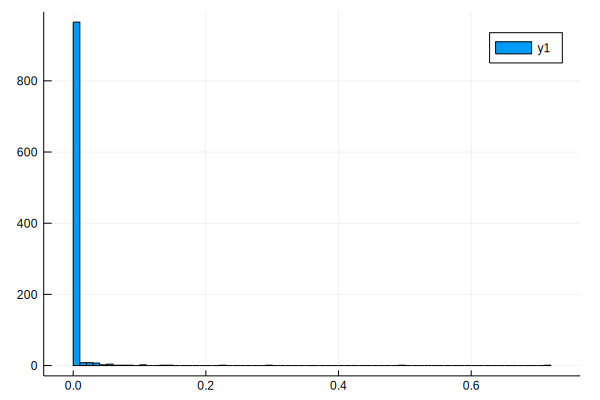

In [58]:
histogram(f,nbins=100)

In [23]:
test=RGB.(v5,v5,0)

In [24]:
using PerceptualColourMaps

In [26]:
test

In [25]:
imgc=PerceptualColourMaps.applycolormap(test, cmap("R3")) 

LoadError: [91mMethodError: no method matching isless(::ColorTypes.RGB{Float64}, ::ColorTypes.RGB{Float64})[0m
Closest candidates are:
  isless([91m::Missings.Missing[39m, ::Any) at C:\Users\User\.julia\v0.6\Missings\src\Missings.jl:74
  isless([91m::PyCall.PyObject[39m, ::Any) at C:\Users\User\.julia\v0.6\PyCall\src\pyoperators.jl:77
  isless(::Any, [91m::Missings.Missing[39m) at C:\Users\User\.julia\v0.6\Missings\src\Missings.jl:75
  ...[39m

In [147]:
G

{1005, 16706} undirected simple Int64 graph